In [1]:
import os
import numpy as np
import imageio
import scipy
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image
from itertools                  import product
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2023-08-18 17:54:54.296688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# def remove_color_profile(image_path, output_path):
#     img = Image.open(image_path)
#     img = img.convert("RGB")
#     img.save(output_path, format="PNG")

# def process_folder(folder_path):
#     for root, _, files in os.walk(folder_path):
#         for filename in files:
#             if filename.lower().endswith(".png"):
#                 input_path = os.path.join(root, filename)
#                 output_path = input_path  
                
#                 remove_color_profile(input_path, output_path)
#                 print(f"Processed: {input_path}")

# input_folder = '/Users/arina/study/ds/project/food_recommendation/bbc_goodfood/project_food/notebooks/model/photo2ingredients/grocery_store/copy_dataset/GroceryStoreDataset/dataset'
# process_folder(input_folder)

In [3]:
TRAIN_DIR = '/Users/allaartukevic/arina/dataset/dataset/train'
TEST_DIR = '/Users/allaartukevic/arina/dataset/dataset/test'
VALIDATION_DIR = '/Users/allaartukevic/arina/dataset/dataset/val'


batch_size = 32
img_size = 224


#### Define sets

In [4]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="training",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="validation",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2640 files belonging to 43 classes.
Using 2112 files for training.
Found 2485 files belonging to 43 classes.
Found 2640 files belonging to 43 classes.
Using 528 files for validation.


In [5]:
train_class_names = training_set.class_names
list(map(str.lower, train_class_names))

['apple',
 'asparagus',
 'aubergine',
 'avocado',
 'banana',
 'brown-cap-mushroom',
 'cabbage',
 'carrots',
 'cucumber',
 'garlic',
 'ginger',
 'juice',
 'kiwi',
 'leek',
 'lemon',
 'lime',
 'mango',
 'melon',
 'milk',
 'nectarine',
 'oat-milk',
 'oatghurt',
 'onion',
 'orange',
 'papaya',
 'passion-fruit',
 'peach',
 'pear',
 'pepper',
 'pineapple',
 'plum',
 'pomegranate',
 'potato',
 'red-beet',
 'red-grapefruit',
 'satsumas',
 'sour-cream',
 'sour-milk',
 'soy-milk',
 'soyghurt',
 'tomato',
 'yoghurt',
 'zucchini']

In [6]:
y_train = training_set.class_names
y_test = test_set.class_names
y_validation = validation_set.class_names

In [7]:
set(y_train) - set(y_test)

{'Brown-Cap-Mushroom'}

#### example of images in train dataset

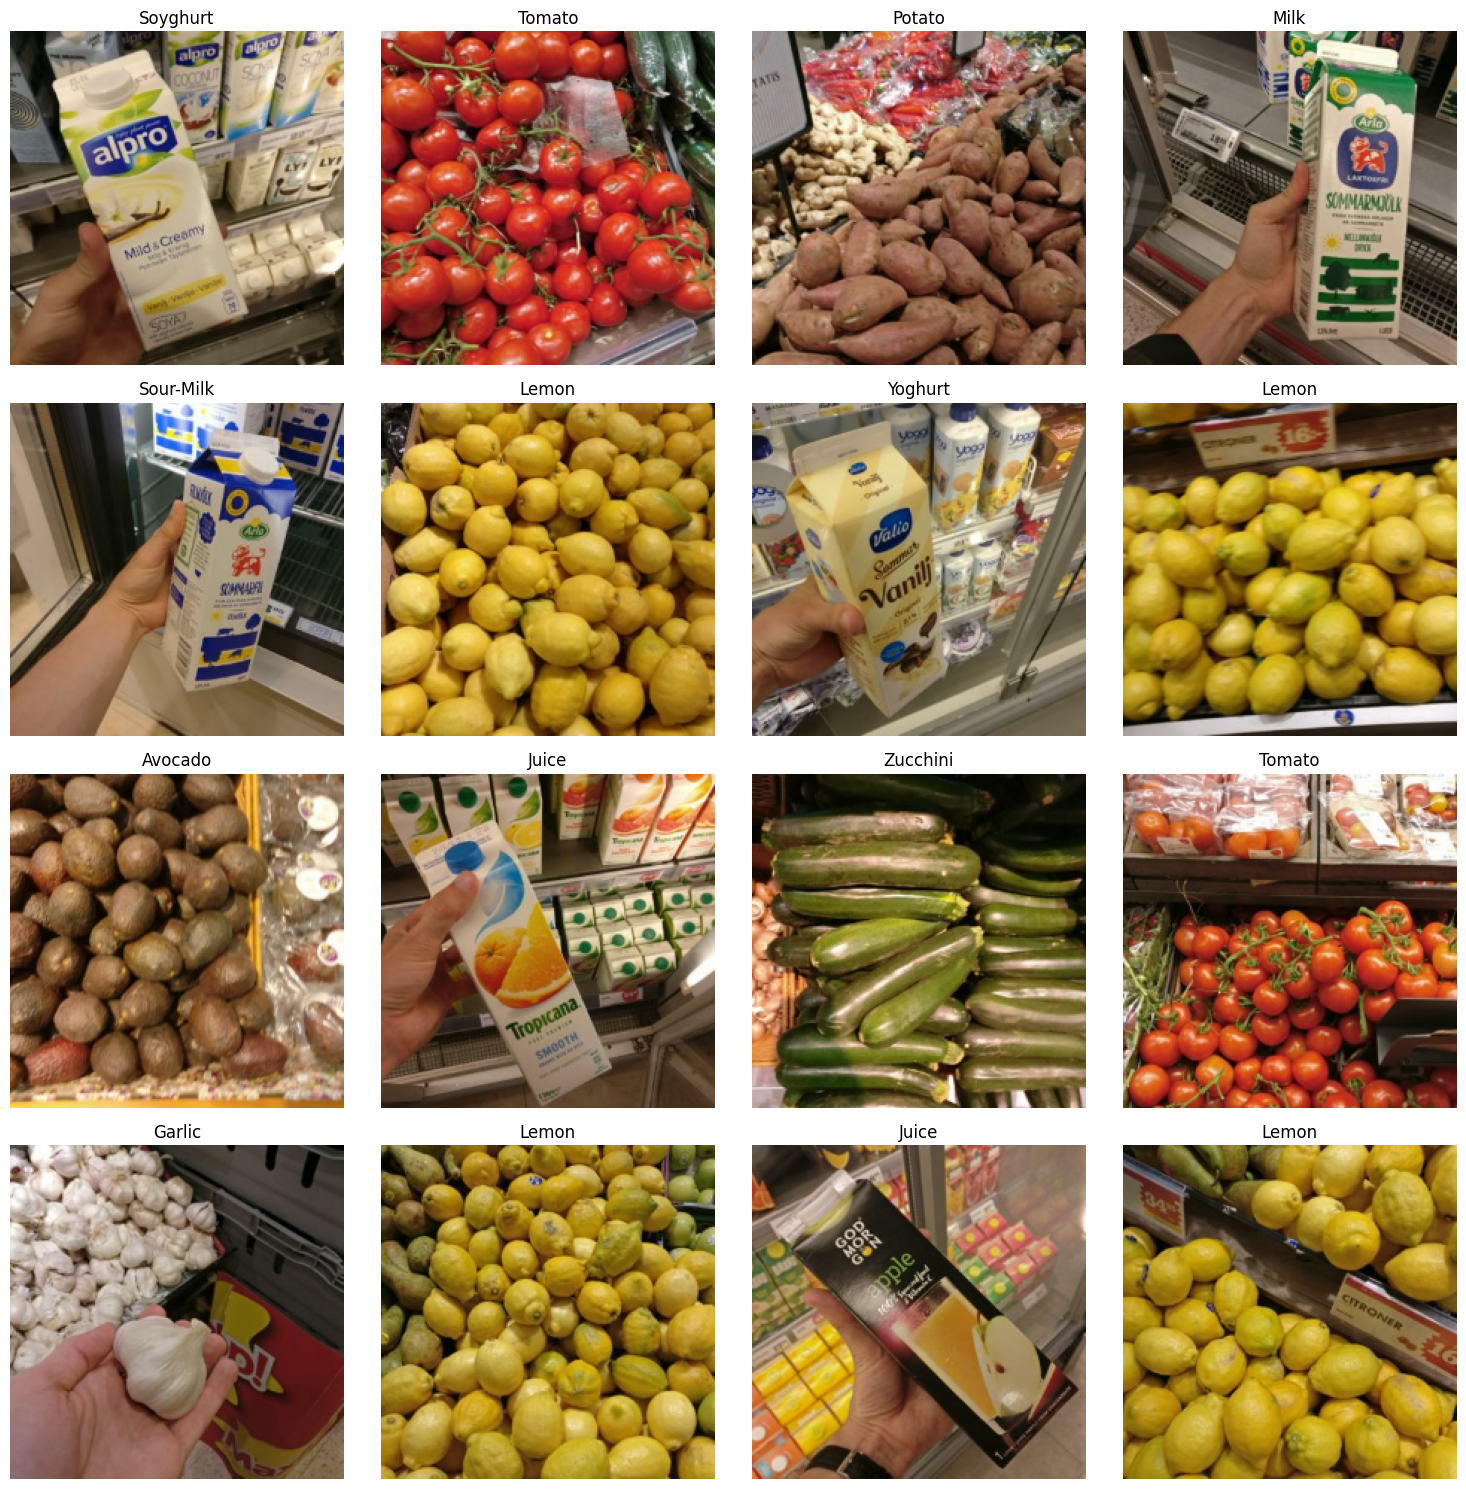

In [8]:
num_rows = 4
num_cols = 4
plt.figure(figsize=(15, 15))

for images, labels in training_set.take(1): 
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(y_train[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

#### Building model

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False

In [10]:
inputs_layer = tf.keras.Input(shape=(img_size, img_size, 3))

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs_layer)

x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)

# x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# x = base_model(x, training=False)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs_layer = tf.keras.layers.Dense(units=len(training_set.class_names), activation='softmax')(x)

In [11]:
model = tf.keras.Model(inputs=inputs_layer, outputs=outputs_layer, name="photo2ingredients")

In [12]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

In [13]:
model.summary()

Model: "photo2ingredients"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                         

In [14]:
history = model.fit(x=training_set,
                    epochs=6,
                    validation_data=validation_set
                    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, verbose=1, restore_best_weights=True)]
                    )

Epoch 1/6


66/66 [==============================] - 119s 1s/step - loss: 1.4611 - accuracy: 0.5971 - val_loss: 0.5632 - val_accuracy: 0.8409
Epoch 2/6
66/66 [==============================] - 91s 1s/step - loss: 0.4897 - accuracy: 0.8518 - val_loss: 0.4778 - val_accuracy: 0.8428
Epoch 3/6
66/66 [==============================] - 95s 1s/step - loss: 0.3075 - accuracy: 0.9081 - val_loss: 0.3721 - val_accuracy: 0.8750
Epoch 4/6
66/66 [==============================] - 96s 1s/step - loss: 0.2386 - accuracy: 0.9257 - val_loss: 0.2894 - val_accuracy: 0.9053
Epoch 5/6
66/66 [==============================] - 91s 1s/step - loss: 0.1948 - accuracy: 0.9375 - val_loss: 0.3057 - val_accuracy: 0.8939
Epoch 6/6
66/66 [==============================] - 88s 1s/step - loss: 0.1708 - accuracy: 0.9437 - val_loss: 0.2220 - val_accuracy: 0.9280


In [15]:
predictions = model.predict(test_set, verbose=1)

78/78 [==============================] - 76s 905ms/step


In [16]:
test_class_names = test_set.class_names

In [17]:
labels_array = np.array([])
pred_array = np.array([])

for x, y in test_set.take(1):
    pred_prob = model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])    
    
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))
print(len(labels_array))
label_vs_pred = [(training_set.class_names[int(label)], training_set.class_names[int(pred_val)]) for label, pred_val in zip(labels_array, pred_array) if label != pred_val]
print(label_vs_pred)

1/1 [==============================] - 6s 6s/step
Accuracy On Test Dataset:  0.375
32
[('Ginger', 'Juice'), ('Passion-Fruit', 'Red-Beet'), ('Ginger', 'Juice'), ('Sour-Cream', 'Milk'), ('Satsumas', 'Orange'), ('Oatghurt', 'Milk'), ('Satsumas', 'Apple'), ('Melon', 'Milk'), ('Melon', 'Milk'), ('Cabbage', 'Carrots'), ('Carrots', 'Cucumber'), ('Soyghurt', 'Juice'), ('Mango', 'Melon'), ('Onion', 'Apple'), ('Mango', 'Melon'), ('Melon', 'Milk'), ('Lemon', 'Apple'), ('Satsumas', 'Orange'), ('Ginger', 'Juice'), ('Melon', 'Milk')]


In [18]:
def plot_graghs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

#### Mistakes in test dataset

In [19]:
# plt.figure(figsize=(15, 10))
# for images, labels in test_set.take(1):
#     for i in range(len(images)):
#         plt.subplot(4, 8, i + 1) 
#         plt.imshow(images[i].numpy().astype('uint8'))
#         predicted_class = np.argmax(predictions[i])
#         confidence = predictions[i][predicted_class]
#         true_class = test_class_names[labels[i]]
#         predicted_class_name = test_class_names[predicted_class]
#         # plt.title(f"{true_class, tf.get_static_value(labels[i])} \n {predicted_class_name, predicted_class}")
#         plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
#         plt.axis('off')
# plt.tight_layout()
# plt.show()

In [20]:
# for images, labels in test_set:
#     predictions = model.predict(images)
#     predicted_class = np.argmax(predictions[0])
#     true_class = test_class_names[labels[0]]
    
#     if predicted_class != labels[0]: 
#         plt.figure()
#         plt.imshow(images[0].numpy().astype('uint8'))
#         confidence = predictions[0][predicted_class]
#         predicted_class_name = test_class_names[predicted_class]
#         plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
#         plt.axis('off')
        
# plt.show()

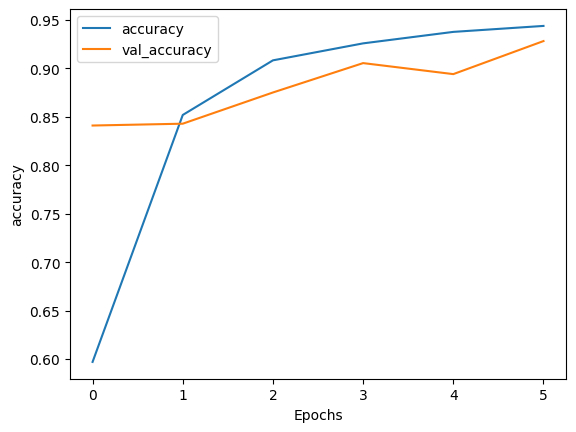

In [21]:
plot_graghs(history, 'accuracy')

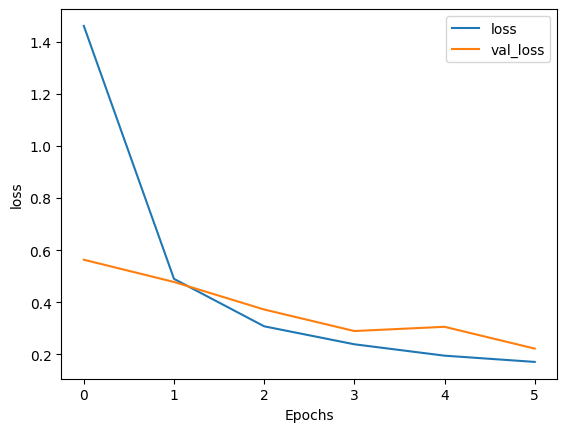

In [22]:
plot_graghs(history, 'loss')

In [23]:
model.save("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/grocery_ds_photo2ingredients.h5")

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# model = keras.models.load_model("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/grocery_ds_photo2ingredients.h5")

In [25]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix


In [26]:
train_pred = model.predict(training_set)
test_pred = model.predict(test_set)

train_pred_labels = np.argmax(train_pred, axis=1)
test_pred_labels = np.argmax(test_pred, axis=1)

train_true_labels = np.concatenate([y for x, y in training_set], axis=0)
test_true_labels = np.concatenate([y for x, y in test_set], axis=0)


78/78 [==============================] - 71s 911ms/step


In [27]:
result = [(training_set.class_names[int(label)], training_set.class_names[int(pred)]) for label, pred in zip(train_true_labels, train_pred_labels) if label != pred]
print(len(result))

2014


In [28]:
result = [(label, pred) for label, pred in zip(test_true_labels, test_pred_labels) if label != pred]
print(result)

[(28, 12), (36, 41), (26, 23), (10, 17), (16, 23), (0, 17), (22, 0), (39, 17), (28, 22), (41, 18), (28, 2), (41, 7), (41, 39), (16, 3), (28, 23), (16, 27), (27, 40), (40, 18), (28, 21), (10, 2), (39, 40), (6, 0), (34, 2), (27, 11), (0, 19), (27, 17), (0, 34), (28, 0), (28, 42), (41, 11), (30, 40), (40, 0), (41, 40), (29, 27), (2, 29), (15, 11), (40, 17), (22, 28), (10, 28), (41, 0), (3, 19), (17, 9), (23, 9), (35, 27), (10, 23), (16, 40), (16, 26), (0, 3), (0, 18), (17, 28), (10, 0), (35, 0), (0, 16), (41, 27), (0, 21), (35, 18), (0, 2), (17, 41), (16, 35), (36, 0), (16, 18), (6, 0), (20, 0), (17, 11), (38, 0), (35, 5), (12, 41), (32, 0), (27, 35), (10, 9), (16, 23), (32, 11), (23, 32), (0, 11), (16, 13), (28, 32), (10, 27), (38, 11), (17, 23), (21, 32), (16, 27), (10, 17), (35, 23), (41, 0), (2, 18), (7, 0), (22, 11), (8, 41), (35, 4), (25, 28), (19, 22), (40, 7), (10, 18), (28, 0), (10, 18), (15, 41), (16, 40), (37, 8), (28, 0), (2, 11), (21, 11), (27, 25), (22, 11), (40, 17), (16, 0

In [29]:
train_confusion_mtx = confusion_matrix(train_true_labels, train_pred_labels)
train_classification_rep = classification_report(train_true_labels, train_pred_labels)

test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)


In [30]:
train_confusion_mtx = confusion_matrix(train_true_labels, train_pred_labels)
train_classification_rep = classification_report(train_true_labels, train_pred_labels)

test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)


In [31]:
print("Train Confusion Matrix:")
print(train_confusion_mtx)
print("\nTrain Classification Report:")
print(train_classification_rep)

print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)


Train Confusion Matrix:
[[27  3  2 ...  8 12  2]
 [ 1  0  0 ...  1  1  1]
 [ 2  0  0 ...  0  1  0]
 ...
 [11  0  0 ...  3  2  1]
 [19  0  3 ...  7  9  2]
 [ 4  0  1 ...  2  0  0]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.11       231
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        17
           3       0.09      0.09      0.09        34
           4       0.03      0.03      0.03        39
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        17
          11       0.08      0.08      0.08       191
          12       0.00      0.00      0.00        36
          13       0.00      0.00

In [32]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="training",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="validation",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2640 files belonging to 43 classes.
Using 2112 files for training.
Found 2485 files belonging to 43 classes.
Found 2640 files belonging to 43 classes.
Using 528 files for validation.


In [33]:
from tensorflow.keras import layers, models
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

In [34]:
image_size = (img_size, img_size)
num_classes = len(training_set.class_names)  

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
])

simple_model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    data_augmentation,
    preprocessing.Rescaling(1.0 / 255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

simple_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_simple = simple_model.fit(training_set, validation_data=validation_set, epochs=10)


Epoch 1/10


/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


66/66 [==============================] - 160s 2s/step - loss: 3.3433 - accuracy: 0.1610 - val_loss: 2.9461 - val_accuracy: 0.2443
Epoch 2/10
66/66 [==============================] - 145s 2s/step - loss: 2.6544 - accuracy: 0.2940 - val_loss: 2.5633 - val_accuracy: 0.2973
Epoch 3/10
66/66 [==============================] - 141s 2s/step - loss: 2.2359 - accuracy: 0.3542 - val_loss: 2.1337 - val_accuracy: 0.3693
Epoch 4/10
66/66 [==============================] - 143s 2s/step - loss: 1.9430 - accuracy: 0.4143 - val_loss: 1.9411 - val_accuracy: 0.4375
Epoch 5/10
66/66 [==============================] - 143s 2s/step - loss: 1.7509 - accuracy: 0.4522 - val_loss: 1.7151 - val_accuracy: 0.4564
Epoch 6/10
66/66 [==============================] - 149s 2s/step - loss: 1.4650 - accuracy: 0.5185 - val_loss: 1.5546 - val_accuracy: 0.5284
Epoch 7/10
66/66 [==============================] - 153s 2s/step - loss: 1.3171 - accuracy: 0.5710 - val_loss: 1.4431 - val_accuracy: 0.5492
Epoch 8/10
66/66 [======

In [35]:
simple_model.save("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/grocery_ds_simple_model.h5")
# simple_model = keras.models.load_model("/Users/allaartukevic/arina/food_project/model/photo2ingredients/current_model/grocery_ds_simple_model.h5")

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
predictions = simple_model.predict(test_set, verbose=1)

78/78 [==============================] - 42s 519ms/step


In [37]:
labels_array = np.array([])
pred_array = np.array([])
for x, y in test_set.take(1):
    pred_prob = simple_model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])    
    
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))

label_vs_pred = [(training_set.class_names[int(label)], training_set.class_names[int(pred_val)]) for label, pred_val in zip(labels_array, pred_array) if label != pred_val]
print(label_vs_pred)

1/1 [==============================] - 1s 920ms/step
Accuracy On Test Dataset:  0.1875
[('Ginger', 'Juice'), ('Passion-Fruit', 'Garlic'), ('Ginger', 'Avocado'), ('Sour-Cream', 'Soyghurt'), ('Potato', 'Passion-Fruit'), ('Banana', 'Passion-Fruit'), ('Satsumas', 'Orange'), ('Oatghurt', 'Oat-Milk'), ('Satsumas', 'Nectarine'), ('Banana', 'Melon'), ('Oatghurt', 'Oat-Milk'), ('Pear', 'Brown-Cap-Mushroom'), ('Melon', 'Milk'), ('Melon', 'Milk'), ('Cabbage', 'Carrots'), ('Carrots', 'Cucumber'), ('Soyghurt', 'Juice'), ('Onion', 'Pear'), ('Mango', 'Cucumber'), ('Onion', 'Potato'), ('Mango', 'Potato'), ('Melon', 'Pepper'), ('Lemon', 'Zucchini'), ('Satsumas', 'Orange'), ('Ginger', 'Juice'), ('Melon', 'Milk')]


In [38]:
test_pred_labels = np.argmax(predictions, axis=1)
test_true_labels = np.concatenate([y for x, y in test_set], axis=0)


In [39]:
test_confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)
test_classification_rep = classification_report(test_true_labels, test_pred_labels)

print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)



Test Confusion Matrix:
[[30  0 11 ...  5 22  3]
 [ 2  0  1 ...  0  1  0]
 [ 6  0  0 ...  0  1  0]
 ...
 [11  1  1 ...  4  5  3]
 [26  0  1 ...  7  9  3]
 [ 7  0  0 ...  0  1  0]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.11      0.10       276
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        22
           3       0.07      0.03      0.04        40
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        42
           7       0.06      0.07      0.07        27
           8       0.02      0.04      0.03        25
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00       219
          11       0.01      0.07      0.02        45
          12       0.00      0.00      0.00        21
          13       0.00      0.00 

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

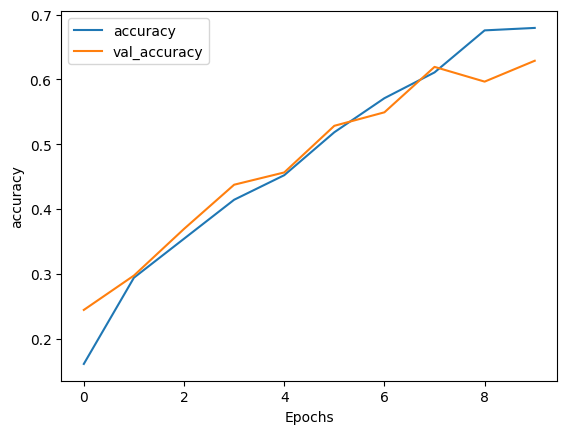

In [40]:
plot_graghs(history_simple, 'accuracy')

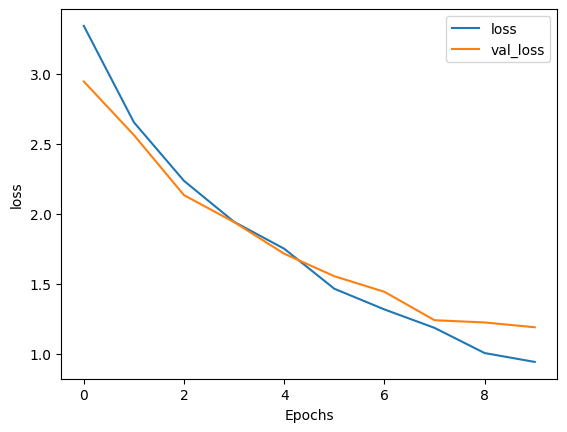

In [41]:
plot_graghs(history_simple, 'loss')